In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
# Sets the seed for generating random numbers. Returns a torch.Generator object.
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

In [37]:
# 从cifar10里拿出飞机和鸟组成新的数据集，这个是datasets的子类
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
            for img, label in cifar10
            if label in [0, 2]]
cifar2_val = [(img, label_map[label])
                for img, label in cifar10_val
                if label in [0, 2]]

len(cifar2)

10000

In [6]:
import torch.nn as nn 

n_out = 2 

model = nn.Sequential(
    nn.Linear(
        3072, # input features
        512, # hidden layer size
    ),
    nn.Tanh(),
    nn.Linear(
        512, # hidden layer size 
        n_out,
    )
)

In [7]:
def softmax(x):
    # Returns a new tensor with the exponential of the elements of the input tensor input.
    return torch.exp(x) / torch.exp(x).sum()

In [8]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [9]:
softmax(x).sum()

tensor(1.)

In [10]:
softmax = nn.Softmax(dim=1) # 指定计算列数

x = torch.tensor([[1.0, 2.0, 3.0],
                [1.0, 2.0, 3.0]])

softmax(x), x.shape

(tensor([[0.0900, 0.2447, 0.6652],
         [0.0900, 0.2447, 0.6652]]),
 torch.Size([2, 3]))

In [11]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


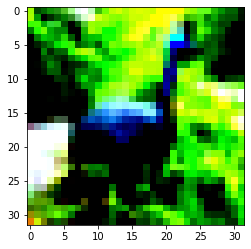

In [12]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [13]:
img_batch = img.view(-1).unsqueeze(0)


In [14]:
# 未训练模型
out = model(img_batch)
# [airplanes, bird]的概率
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)

In [15]:
i, index = torch.max(out, dim=1)

index, i

(tensor([1]), tensor([0.5216], grad_fn=<MaxBackward0>))

In [16]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

x, x.shape, softmax(x)

(tensor([[  0., 104.]]), torch.Size([1, 2]), tensor([[0., 1.]]))

In [17]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [18]:
log_softmax(x)

tensor([[-104.,    0.]])

In [19]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [20]:
mode = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [21]:
loss = nn.NLLLoss()

In [22]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

# 预测out和label的相似程度
loss(out, torch.tensor([label]))

tensor(-0.5216, grad_fn=<NllLossBackward>)

# 在cpu上跑没有batch的数据太慢了，而且很蠢
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss %f" % (epoch, float(loss)))

In [23]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle=True)